## 2.2 开始动手！

### 2.2.1 构建坐标系统

In [1]:
import geopandas as gpd
from shapely.geometry import LineString, Point, Polygon
import matplotlib.pyplot as plt
import numpy as np
import warnings

plt.rcParams['font.sans-serif'] = ['SimHei'] # 解决matplotlib中文乱码问题
plt.rcParams['axes.unicode_minus'] = False # 解决matplotlib负号显示问题
warnings.filterwarnings('ignore')

# 设置中心点在南极点的正射投影
crs = '+proj=ortho +lon_0=0 +lat_0=-90'

# 构建经度线并设置对应经纬度的地理坐标系
lng_lines = gpd.GeoDataFrame({
    'geometry': [LineString([[lng, -90], [lng, -78]]) for lng in np.arange(10, 220, 210 / 38)]}, 
    crs='EPSG:4326')

# 构建纬度线并设置为对应经纬度的地理坐标系
lat_lines = gpd.GeoDataFrame({
    'geometry': [LineString([[lng, lat] for lng in range(10, 220)]) for lat in range(-90, -79, 2)]}, 
    crs='EPSG:4326')

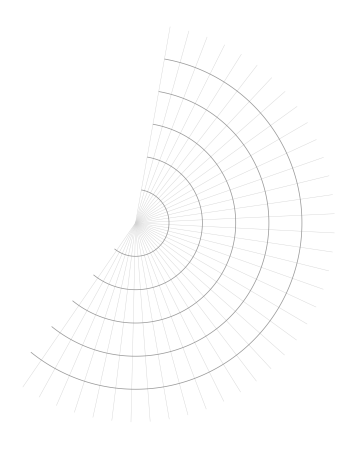

In [2]:
fig, ax = plt.subplots(figsize=(8, 8))

# 绘制经度线与纬度线
ax = lng_lines.to_crs(crs).plot(ax=ax, linewidth=0.4, edgecolor='lightgrey')
lat_lines.to_crs(crs).plot(ax=ax, linewidth=0.75, edgecolor='grey', alpha=0.8)
ax.axis('off'); # 关闭坐标轴

fig.savefig('图6.png', dpi=500, inches_bbox='tight', inches_pad=0)

### 2.2.2 绘制指标折线

In [3]:
import pandas as pd

# 构造指标数据
data = pd.DataFrame({
    '城市': ['长沙', '烟台', '哈尔滨', '贵阳', '乌鲁木齐',
             '沈阳', '南昌', '无锡', '重庆', '昆明', '太原',
             '石家庄', '大连', '佛山', '兰州', '长春', '济南',
             '郑州', '南宁', '武汉', '合肥', '珠海', '宁波',
             '西安', '青岛', '成都', '苏州', '海口', '东莞',
             '天津', '福州', '广州', '南京', '厦门', '杭州',
             '上海', '北京', '深圳'],
    '居住自由指数': [95.7, 95.7, 95.2, 92.4, 91.57, 90.3, 89.2,
                    89.1, 86.6, 85.8, 85.3, 85.3, 85.2, 85.1,
                    83.8, 83.4, 82.1, 82.1, 81.9, 80.2, 78.1,
                    76.9, 76.7, 76.4, 75.6, 75.6, 73.7, 73.3,
                    73.1, 71.5, 68.2, 62.6, 62.4, 50.1, 49.36,
                    22.48, 12.11, 8.09]
})

data.head()

,城市,居住自由指数
0,长沙,95.70
1,烟台,95.70
2,哈尔滨,95.20
3,贵阳,92.40
4,乌鲁木齐,91.57


In [4]:
def fake_index(value):
    
    fake = []
    fake.append(value+np.random.uniform(5, 10))
    fake.append(value-np.random.uniform(5, 10))
    
    return np.random.choice(fake, size=2, replace=False).tolist()

data['购房自由指数'], data['租房自由指数'] = list(zip(*data['居住自由指数'].apply(fake_index)))

# 修正伪造数据中大于100和小于0的情况
data.loc[:, '居住自由指数':] = data.loc[:, '居住自由指数':].applymap(lambda v: 100 if v > 100 else v)
data.loc[:, '居住自由指数':] = data.loc[:, '居住自由指数':].applymap(lambda v: 0 if v < 0 else v)
data.head()

,城市,居住自由指数,购房自由指数,租房自由指数
0,长沙,95.70,89.825274,100.000000
1,烟台,95.70,100.000000,86.792204
2,哈尔滨,95.20,100.000000,88.837647
3,贵阳,92.40,100.000000,85.034628
4,乌鲁木齐,91.57,83.370929,96.813467


In [5]:
def scale(v):
    '''
    线性映射函数
    '''
    
    return -90 + 0.1*v

data['居住自由指数_映射值'] = data['居住自由指数'].apply(scale)
data['购房自由指数_映射值'] = data['购房自由指数'].apply(scale)
data['租房自由指数_映射值'] = data['租房自由指数'].apply(scale)
data.head()

,城市,居住自由指数,购房自由指数,租房自由指数,居住自由指数_映射值,购房自由指数_映射值,租房自由指数_映射值
0,长沙,95.70,89.825274,100.000000,-80.430,-81.017473,-80.000000
1,烟台,95.70,100.000000,86.792204,-80.430,-80.000000,-81.320780
2,哈尔滨,95.20,100.000000,88.837647,-80.480,-80.000000,-81.116235
3,贵阳,92.40,100.000000,85.034628,-80.760,-80.000000,-81.496537
4,乌鲁木齐,91.57,83.370929,96.813467,-80.843,-81.662907,-80.318653


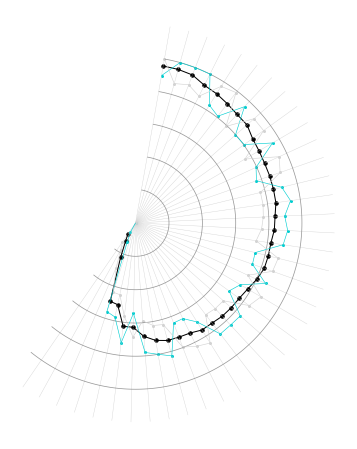

In [6]:
# 为每个城市生成1条经线
lng_lines = gpd.GeoDataFrame({
    'geometry': [LineString([[lng, -90], [lng, -78]]) for lng in np.arange(10, 220, 210 / data.shape[0])]}, 
    crs='EPSG:4326')

# 居住自由指数对应的折线
line1 = gpd.GeoDataFrame({
    'geometry': [LineString([(lng, lat) for lng, lat in zip(np.arange(10, 220, 210 / data.shape[0]),
                                                            data['居住自由指数_映射值'])])]}, 
    crs='EPSG:4326')

# 居住自由指数对应的折线上的散点
scatter1 = gpd.GeoDataFrame({
    'geometry': [Point(lng, lat) for lng, lat in zip(np.arange(10, 220, 210 / data.shape[0]),
                                                     data['居住自由指数_映射值'])]}, crs='EPSG:4326')

# 购房自由指数对应的折线
line2 = gpd.GeoDataFrame({
    'geometry': [LineString([(lng, lat) for lng, lat in zip(np.arange(10, 220, 210 / data.shape[0]),
                                                            data['购房自由指数_映射值'])])]}, 
    crs='EPSG:4326')

# 购房自由指数对应的折线上的散点
scatter2 = gpd.GeoDataFrame({
    'geometry': [Point(lng, lat) for lng, lat in zip(np.arange(10, 220, 210 / data.shape[0]),
                                                     data['购房自由指数_映射值'])]}, crs='EPSG:4326')


# 租房自由指数对应的折线
line3 = gpd.GeoDataFrame({
    'geometry': [LineString([(lng, lat) for lng, lat in zip(np.arange(10, 220, 210 / data.shape[0]),
                                                            data['租房自由指数_映射值'])])]}, 
    crs='EPSG:4326')

# 租房自由指数对应的折线上的散点
scatter3 = gpd.GeoDataFrame({
    'geometry': [Point(lng, lat) for lng, lat in zip(np.arange(10, 220, 210 / data.shape[0]),
                                                     data['租房自由指数_映射值'])]}, crs='EPSG:4326')

                             
fig, ax = plt.subplots(figsize=(8, 8))

# 绘制经度线与纬度线
ax = lng_lines.to_crs(crs).plot(ax=ax, linewidth=0.4, edgecolor='lightgrey')
ax = lat_lines.to_crs(crs).plot(ax=ax, linewidth=0.75, edgecolor='grey', alpha=0.8)
ax = line1.to_crs(crs).plot(ax=ax, color='black', linewidth=1)
ax = scatter1.to_crs(crs).plot(ax=ax, color='black', markersize=12)
ax = line2.to_crs(crs).plot(ax=ax, color='#00CED1', linewidth=0.6)
ax = scatter2.to_crs(crs).plot(ax=ax, color='#00CED1', markersize=4)
ax = line3.to_crs(crs).plot(ax=ax, color='lightgrey', linewidth=0.6)
ax = scatter3.to_crs(crs).plot(ax=ax, color='lightgrey', markersize=4)
ax.axis('off'); # 关闭坐标轴

fig.savefig('图9.png', dpi=500, inches_bbox='tight', inches_pad=0)

### 2.2.3 绘制填充区域

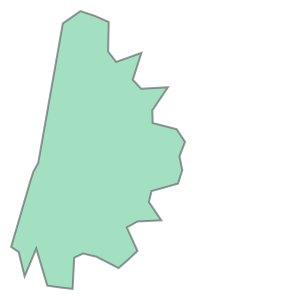

In [7]:
# 购房自由指数_映射值+南极点所围成的面
polygon1 = gpd.GeoDataFrame({
    'geometry': [Polygon([(lng, lat) for lng, lat in zip(np.arange(10, 220, 210 / data.shape[0]),
                                                         data['购房自由指数_映射值'])]+[[0, -90]])]}, 
    crs='EPSG:4326').to_crs(crs)

polygon1.geometry[0]

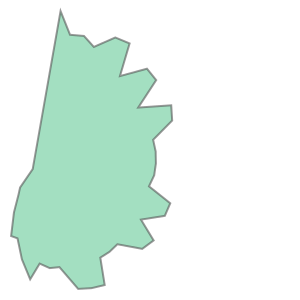

In [8]:
# 租房自由指数_映射值+南极点所围成的面
polygon2 = gpd.GeoDataFrame({
    'geometry': [Polygon([(lng, lat) for lng, lat in zip(np.arange(10, 220, 210 / data.shape[0]),
                                                         data['租房自由指数_映射值'])]+[[0, -90]])]}, 
    crs='EPSG:4326').to_crs(crs)

polygon2.geometry[0]

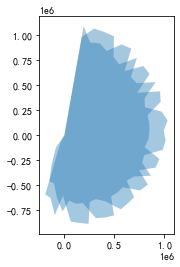

In [9]:
pd.concat([polygon1, polygon2]).plot(alpha=0.4);

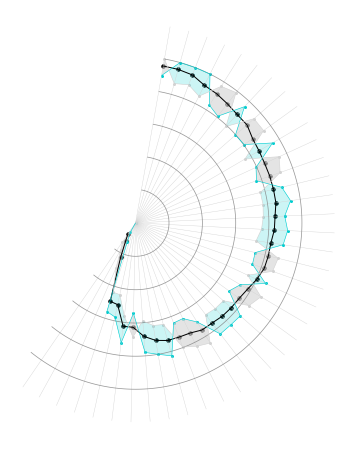

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))

# 绘制经度线与纬度线
ax = lng_lines.to_crs(crs).plot(ax=ax, linewidth=0.4, edgecolor='lightgrey')
ax = lat_lines.to_crs(crs).plot(ax=ax, linewidth=0.75, edgecolor='grey', alpha=0.8)
ax = line1.to_crs(crs).plot(ax=ax, color='black', linewidth=1)
ax = scatter1.to_crs(crs).plot(ax=ax, color='black', markersize=12)
ax = line2.to_crs(crs).plot(ax=ax, color='#00CED1', linewidth=0.6)
ax = scatter2.to_crs(crs).plot(ax=ax, color='#00CED1', markersize=4)
ax = line3.to_crs(crs).plot(ax=ax, color='lightgrey', linewidth=0.6)
ax = scatter3.to_crs(crs).plot(ax=ax, color='lightgrey', markersize=4)
ax = polygon1.difference(polygon2).plot(ax=ax, color='#00CED1', alpha=0.2)
polygon2.difference(polygon1).plot(ax=ax, color='lightgrey', alpha=0.6)
ax.axis('off'); # 关闭坐标轴

fig.savefig('图13.png', dpi=500, inches_bbox='tight', inches_pad=0)

### 2.2.4 补充文字、标注等元素

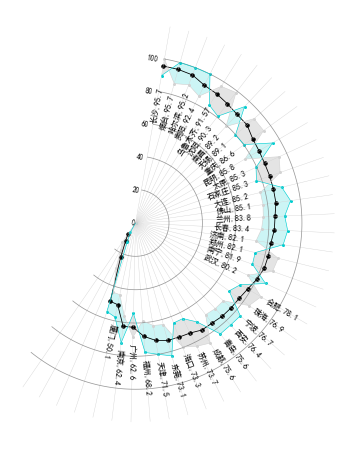

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))

# 绘制经度线与纬度线
ax = lng_lines.to_crs(crs).plot(ax=ax, linewidth=0.4, edgecolor='lightgrey')
ax = lat_lines.to_crs(crs).plot(ax=ax, linewidth=0.75, edgecolor='grey', alpha=0.8)

ax = polygon1.difference(polygon2).plot(ax=ax, color='#00CED1', alpha=0.2)
ax = polygon2.difference(polygon1).plot(ax=ax, color='lightgrey', alpha=0.6)

ax = line1.to_crs(crs).plot(ax=ax, color='black', linewidth=0.8)
ax = scatter1.to_crs(crs).plot(ax=ax, color='black', markersize=12)
ax = line2.to_crs(crs).plot(ax=ax, color='#00CED1', linewidth=0.6)
ax = scatter2.to_crs(crs).plot(ax=ax, color='#00CED1', markersize=4)
ax = line3.to_crs(crs).plot(ax=ax, color='lightgrey', linewidth=0.6)
ax = scatter3.to_crs(crs).plot(ax=ax, color='lightgrey', markersize=4)

ax.axis('off'); # 关闭坐标轴

# 添加文字
text_data = gpd.GeoDataFrame({
    '城市': data['城市'],
    '居住自由指数': data['居住自由指数'],
    '购房自由指数_映射值': data['购房自由指数_映射值'],
    '租房自由指数_映射值': data['租房自由指数_映射值'],
    '锚点经度': np.arange(10, 220, 210 / data.shape[0])
})

text_data.loc[:19, '锚点纬度'] = text_data.loc[:19, '购房自由指数_映射值':'租房自由指数_映射值'].min(axis=1) - 1.8
text_data.loc[20:, '锚点纬度'] = text_data.loc[20:, '购房自由指数_映射值':'租房自由指数_映射值'].max(axis=1) + 1.5
text_data['geometry'] = [Point(lng, lat) for lng, lat in zip(np.arange(10, 220, 210 / data.shape[0]),
                                                             text_data['锚点纬度'])]

text_data = gpd.GeoDataFrame(text_data, crs='EPSG:4326').to_crs(crs)

for row in text_data.loc[:19].itertuples():
    
    ax.text(getattr(row, 'geometry').x, 
            getattr(row, 'geometry').y, 
            getattr(row, '城市')+','+str(getattr(row, '居住自由指数')),
            rotation=78-(getattr(row, '锚点经度')-12),
            fontsize=8,
            va='center',
            ha='center')
    
for row in text_data.loc[20:].itertuples():
    
    if getattr(row, '城市') == '杭州':
        break
    
    ax.text(getattr(row, 'geometry').x, 
            getattr(row, 'geometry').y, 
            getattr(row, '城市')+','+str(getattr(row, '居住自由指数')),
            rotation=78-(getattr(row, '锚点经度')-12),
            fontsize=8,
            va='center',
            ha='center')

# 添加刻度文字
tick_text = gpd.GeoDataFrame({
    'value': [i*10 for i in range(0, 11, 2)],
    'geometry': [Point(7.8, lat) for lat in range(-90, -79, 2)]}, 
    crs='EPSG:4326').to_crs(crs)

for row in tick_text.itertuples():
    
    ax.text(getattr(row, 'geometry').x, 
            getattr(row, 'geometry').y,
            getattr(row, 'value'),
            rotation=-10,
            ha='right',
            va='center',
            fontsize=7.5)
    

fig.savefig('图14.png', dpi=500, inches_bbox='tight', inches_pad=0)